In [1]:
pip install tensorflow

     |████████████████████████████████| 479.6MB 3.8MB/s eta 0:00:019     |███████████████████████████▋    | 413.6MB 6.4MB/s eta 0:00:11
     |████████████████████████████████| 61kB 6.8MB/s eta 0:00:011
     |████████████████████████████████| 61kB 7.2MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 4.0MB/s eta 0:00:01
     |████████████████████████████████| 450kB 4.6MB/s eta 0:00:01
     |████████████████████████████████| 24.5MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 143kB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 829kB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 92kB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 2.4MB 4.4MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 4.0MB/s eta 0:00:01
     |██▌                             | 430kB 3.1MB/s eta 0:00:02Collecti

     |████████████████████████████████| 184kB 4.8MB/s eta 0:00:01
     |████████████████████████████████| 163kB 5.1MB/s eta 0:00:01
     |████████████████████████████████| 143kB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 122kB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 71kB 6.5MB/s eta 0:00:01
     |████████████████████████████████| 92kB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 153kB 4.9MB/s eta 0:00:01
ERROR: sqlalchemy 2.0.28 has requirement typing-extensions>=4.6.0, but you'll have typing-extensions 4.5.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement importlib-metadata!=4.7.0,<7,>=3.7.0, but you'll have importlib-metadata 7.1.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement packaging<24, but you'll have packaging 24.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement cloudpickle==1.6.0, but you'll 

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sklearn

    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-fayynqpc/sklearn/setup.py'"'"'; __file__='"'"'/tmp/pip-install-fayynqpc/sklearn/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-install-fayynqpc/sklearn/pip-egg-info
         cwd: /tmp/pip-install-fayynqpc/sklearn/
    Complete output (15 lines):
    The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
    rather than 'sklearn' for pip commands.
    
    Here is how to fix this error in the main use cases:
    - use 'pip install scikit-learn' rather than 'pip install sklearn'
    - replace 'sklearn' by 'scikit-learn' in your pip requirements files
      (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
    - if the 'sklearn' package is used by one of your dep

In [3]:
pip install seaborn

     |████████████████████████████████| 296kB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 9.2MB 26.8MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 37.7MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 30.0MB/s eta 0:00:01
     |████████████████████████████████| 112kB 36.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 39.3MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 42.1MB/s eta 0:00:01
     |████████████████████████████████| 235kB 57.9MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 47.8MB/s eta 0:00:01
     |████████████████████████████████| 307kB 55.7MB/s eta 0:00:01
     |████████████████████████████████| 4.7MB 38.6MB/s eta 0:00:01
ERROR: refractio 2.1.5.4 has requirement pandas==2.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: mlflow 2.6.0 has requirement packaging<24, but you'll have packaging 24.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement pytz<2024, but 

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install refractml

     |████████████████████████████████| 51kB 1.7MB/s eta 0:00:011
     |████████████████████████████████| 71kB 2.1MB/s eta 0:00:011
     |████████████████████████████████| 61kB 9.8MB/s eta 0:00:011
     |████████████████████████████████| 143kB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 706kB 18.9MB/s eta 0:00:01
     |████████████████████████████████| 9.8MB 60.0MB/s eta 0:00:01
     |████████████████████████████████| 51kB 41.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 53.5MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 54.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 37.6MB/s eta 0:00:01
     |████████████████████████████████| 34.5MB 34.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 53.0MB/s eta 0:00:01
     |████████████████████████████████| 143kB 58.2MB/s eta 0:00:01
     |████████████████████████████████| 163kB 1.6MB/s eta 0:00:01
Failed to build shutils
ERROR: mlflow 2.6.0 has requirement pytz<202

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

Uninstalling urllib3-2.2.1:
  Successfully uninstalled urllib3-2.2.1
     |████████████████████████████████| 143kB 1.4MB/s eta 0:00:01
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement cloudpickle==1.6.0, but you'll have cloudpickle 2.2.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement PyYAML==6.0, but you'll have pyyaml 6.0.1 which is incompatible.
ERROR: mosaic-ai-client 1.0.0 has requirement matplotlib==3.1.1, but you'll have matplotlib 3.7.5 which is incompatible.
ERROR: jupyterlab-server 2.25.4 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import time
import seaborn as sns
from snowflake.snowpark.session import Session
import configparser

import warnings
warnings.filterwarnings("ignore")

config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

Matplotlib created a temporary cache directory at /tmp/matplotlib-xr17o1uw because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


connection successful!


In [6]:
df = session.table("CPG_WAREHOUSE").to_pandas()

In [7]:
df.duplicated().sum()
df.isnull().sum()

DATE                                 0
WARE_HOUSE_ID                        0
WH_MANAGER_ID                        0
LOCATION_TYPE                        0
WH_CAPACITY_SIZE                     0
ZONE                                 0
WH_REGIONAL_ZONE                     0
REFILL_REQUESTS                      0
TRANSPORT_ISSUE                      0
NO_OF_COMPETITOR                     0
NO_OF_RETAILERS                      0
WAREHOUSE_OWNERSHIP                  0
NUMBER_OF_DISTRIBUTORS               0
FLOOD_IMPACTED                       0
FLOOD_PROOF                          0
ELECTRIC_SUPPLY                      0
DIST_FROM_HUB                        0
WORKERS_NUM                        990
WH_EST_YEAR                     166335
STORAGE_ISSUE_REPORTED               0
TEMP_REG_MACH                        1
APPROVED_WH_GOVT_CERTIFICATE         1
WH_BREAKDOWN                         1
GOVT_CHECK                           1
PRODUCT_WG_TON                       1
dtype: int64

In [8]:
df['WORKERS_NUM'] = df['WORKERS_NUM'].fillna(df['WORKERS_NUM'].mean())

In [9]:
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 'NA']
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != '0']
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 0]

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65394
A+    58674
Name: count, dtype: int64

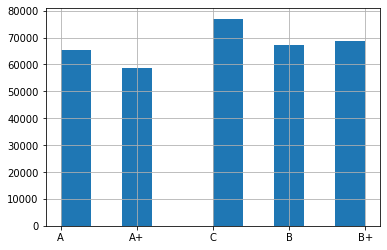

In [10]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

[Text(0.5, 1.0, 'Location Type by zone')]

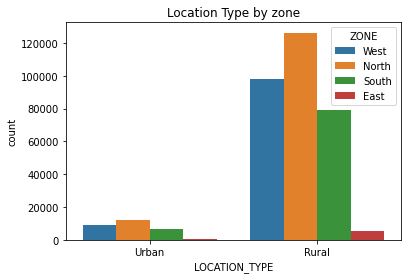

In [11]:
sns.countplot(data=df,x='LOCATION_TYPE',hue='ZONE').set(title='Location Type by zone')

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

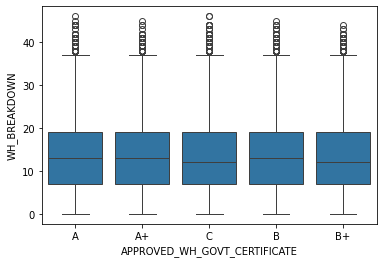

In [12]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [13]:
#label encoder turns label into numeric data
le = LabelEncoder()
df['LOCATION_TYPE']=le.fit_transform(df['LOCATION_TYPE'])
df['WH_CAPACITY_SIZE']=le.fit_transform(df['WH_CAPACITY_SIZE'])
df['APPROVED_WH_GOVT_CERTIFICATE']=le.fit_transform(df['APPROVED_WH_GOVT_CERTIFICATE'])
df['ZONE']=le.fit_transform(df['ZONE'])
df['WH_REGIONAL_ZONE']= le.fit_transform(df['WH_REGIONAL_ZONE'])
df['WAREHOUSE_OWNERSHIP']=le.fit_transform(df['WAREHOUSE_OWNERSHIP'])
## can also use the code below to transform into numeric data by removing "Zone" using lambda expression
##df['WH_regional_zone']=df['WH_regional_zone'].apply(lambda x: x.split(' ')[1]-1)

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

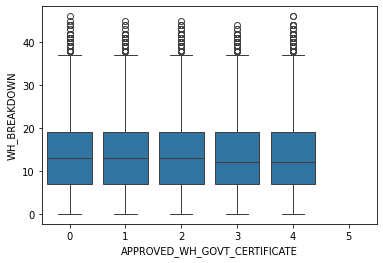

In [14]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [15]:
df = df[df.APPROVED_WH_GOVT_CERTIFICATE != 5]

<Axes: xlabel='APPROVED_WH_GOVT_CERTIFICATE', ylabel='WH_BREAKDOWN'>

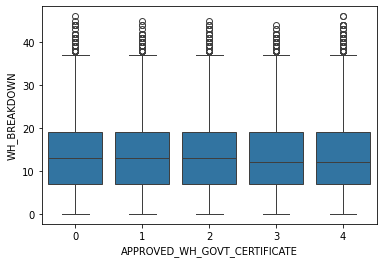

In [16]:
sns.boxplot(data=df,x='APPROVED_WH_GOVT_CERTIFICATE',y='WH_BREAKDOWN')

In [17]:
df = df.drop(['WARE_HOUSE_ID','WH_MANAGER_ID','WH_EST_YEAR','DATE'],axis=1)

<Axes: >

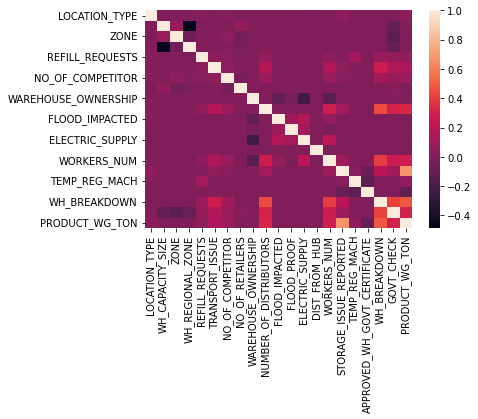

In [18]:
sns.heatmap(df.corr())

In [19]:
#separate the class feature from the rest of the dataset
X = df.drop('APPROVED_WH_GOVT_CERTIFICATE',axis=1).values
y = df['APPROVED_WH_GOVT_CERTIFICATE'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
scaler = MinMaxScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [21]:
print('X train shape: ',X_train.shape)
print('X test shape: ',X_test.shape)

X train shape:  (269829, 20)
X test shape:  (67458, 20)


In [22]:
#define a deep learning model
model = Sequential()

#20 neurons first layer because 20 inputs
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))

#5 neurons for last layer because 5 classes (grade of govt certificate)
model.add(Dense(5,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
#fit the model with data
history = model.fit(x=X_train,
          y=y_train, epochs=90,
          validation_data=(X_test, y_test), verbose=1
          )

Epoch 1/90
8433/8433 [==============================] - 16s 2ms/step - loss: 1.5036 - accuracy: 0.3026 - val_loss: 1.4925 - val_accuracy: 0.3182
Epoch 2/90
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4895 - accuracy: 0.3186 - val_loss: 1.4875 - val_accuracy: 0.3216
Epoch 3/90
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4854 - accuracy: 0.3248 - val_loss: 1.4836 - val_accuracy: 0.3286
Epoch 4/90
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4827 - accuracy: 0.3276 - val_loss: 1.4795 - val_accuracy: 0.3286
Epoch 5/90
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4802 - accuracy: 0.3289 - val_loss: 1.4797 - val_accuracy: 0.3283
Epoch 6/90
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4782 - accuracy: 0.3300 - val_loss: 1.4760 - val_accuracy: 0.3331
Epoch 7/90
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4769 - accuracy: 0.3308 - val_loss: 1.4755 - val_ac

In [21]:
losses = {'loss':history.history['loss'],'val_loss':history.history['val_loss']}
losses = pd.DataFrame(losses)
losses.plot()

NameError: name 'history' is not defined

In [24]:
#define an earlystopper function
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [25]:
#create another model
model = Sequential()

#20 neurons first layer because 20 inputs
model.add(Dense(20,activation='relu'))

model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))

#5 neurons for last layer because 5 classes
model.add(Dense(5,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
#add an early stop as a callback
#this will stop the model fitting  when the validation loss is higher than the training loss after an x amount of epochs (this case 25)
history = model.fit(x=X_train,
          y=y_train, epochs=300,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/300
8433/8433 [==============================] - 16s 2ms/step - loss: 1.5028 - accuracy: 0.3050 - val_loss: 1.4900 - val_accuracy: 0.3195
Epoch 2/300
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4904 - accuracy: 0.3187 - val_loss: 1.4865 - val_accuracy: 0.3258
Epoch 3/300
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4864 - accuracy: 0.3238 - val_loss: 1.4838 - val_accuracy: 0.3277
Epoch 4/300
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4832 - accuracy: 0.3273 - val_loss: 1.4811 - val_accuracy: 0.3271
Epoch 5/300
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4803 - accuracy: 0.3306 - val_loss: 1.4774 - val_accuracy: 0.3318
Epoch 6/300
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4779 - accuracy: 0.3312 - val_loss: 1.4779 - val_accuracy: 0.3306
Epoch 7/300
8433/8433 [==============================] - 15s 2ms/step - loss: 1.4764 - accuracy: 0.3319 - val_loss: 1.4772 -

Epoch 56: early stopping


In [21]:
import matplotlib.pyplot as plt

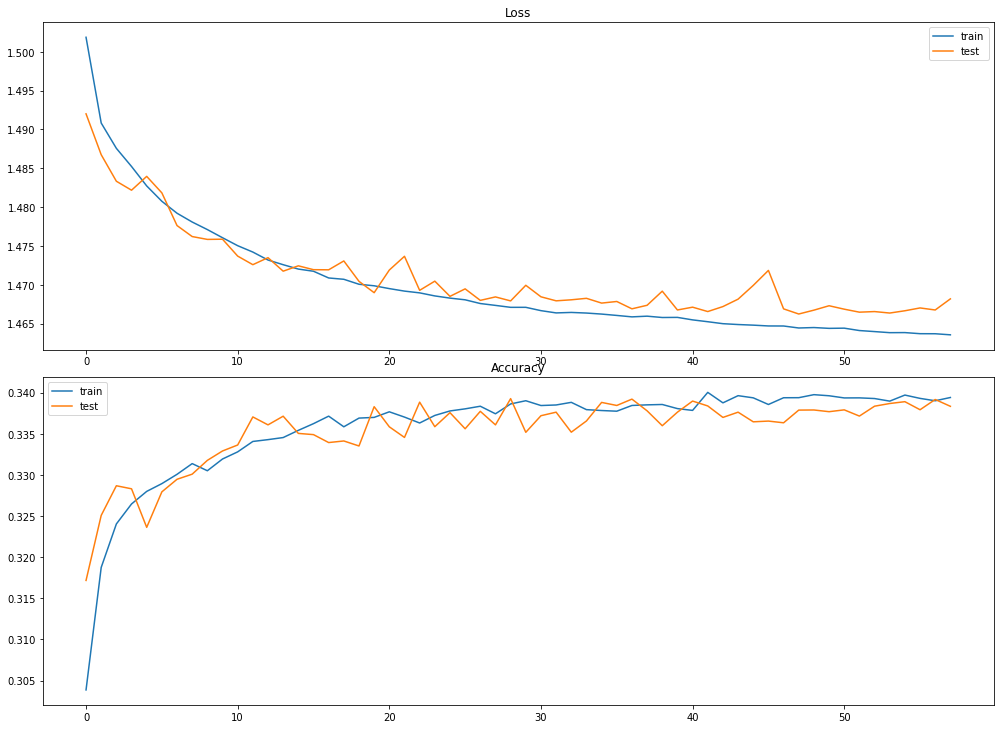

<Figure size 432x288 with 0 Axes>

In [22]:
#plot the loss and validation loss of the model
plt.figure(figsize=(14,10))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.tight_layout()
# plot accuracy and validation accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
plt.tight_layout()

In [23]:
##evaluate the model and print out the accuracy and loss
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
testLoss, testAcc = model.evaluate(X_test, y_test, verbose=0)

print('Train Accuracy: %.2f, Test Accuracy: %.2f' % (trainAcc*100, testAcc*100))
print('Train Loss: %.2f, Test Loss: %.2f' % (trainLoss*100, testLoss*100))


Train Accuracy: 33.94, Test Accuracy: 33.83
Train Loss: 146.41, Test Loss: 146.82


In [24]:
#make predictions --> currently a probability
yProbs = model.predict(X_test)

#turn the yprobs into class labels using argmax to round the value to whole num
yPreds = yProbs.argmax(axis=1)

2109/2109 [==============================] - 2s 1ms/step


In [25]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_curve,roc_auc_score,recall_score,roc_auc_score


              precision    recall  f1-score   support

           0       0.29      0.24      0.26     13008
           1       0.47      0.67      0.55     11724
           2       0.28      0.05      0.09     13554
           3       0.29      0.36      0.32     13749
           4       0.31      0.40      0.35     15423

    accuracy                           0.34     67458
   macro avg       0.33      0.34      0.31     67458
weighted avg       0.32      0.34      0.31     67458



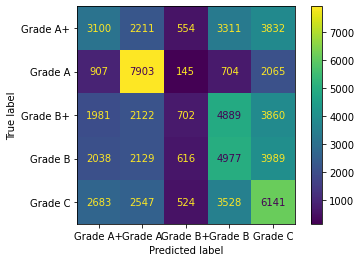

In [26]:
#print out a classification report
print(classification_report(y_test,yPreds))

conMat = confusion_matrix(y_test,yPreds)

#make a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conMat,display_labels=['Grade A+','Grade A','Grade B+','Grade B','Grade C'])
disp.plot()

              precision    recall  f1-score   support

           0       0.29      0.24      0.26     13008
           1       0.47      0.67      0.55     11724
           2       0.28      0.05      0.09     13554
           3       0.29      0.36      0.32     13749
           4       0.31      0.40      0.35     15423

    accuracy                           0.34     67458
   macro avg       0.33      0.34      0.31     67458
weighted avg       0.32      0.34      0.31     67458

2109/2109 [==============================] - 2s 1ms/step
ROC AUC:  0.663242985123927


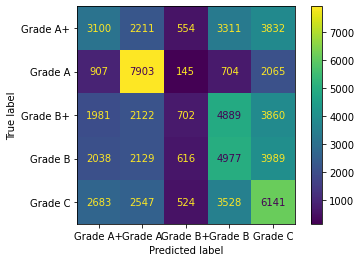

In [27]:
#print out a classification report
print(classification_report(y_test,yPreds))

#print ROC AUC
roc_auc = roc_auc_score(y_test, model.predict(X_test), multi_class='ovr')
print('ROC AUC: ', roc_auc)

conMat = confusion_matrix(y_test,yPreds)

#make a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conMat,display_labels=['Grade A+','Grade A','Grade B+','Grade B','Grade C'])
disp.plot()

2109/2109 [==============================] - 2s 1ms/step


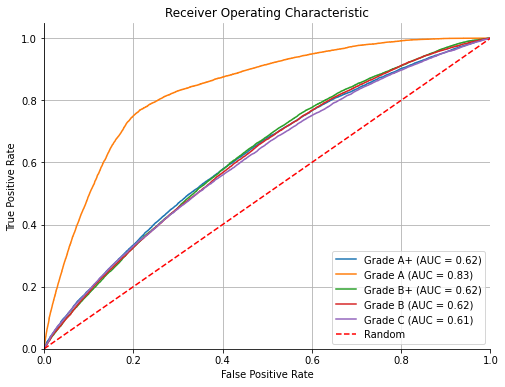

In [28]:
#plot roc curve of the model
y_test = pd.get_dummies(y_test)

class_probabilities = model.predict(X_test)
plt.figure(figsize=(8, 6))
rank = ['dummy','A+','A','B+','B','C']
for i in range(1, class_probabilities.shape[1]+1):
    fpr, tpr, _ = roc_curve(y_test.values[:, i-1], class_probabilities[:, i-1])
    roc_auc = roc_auc_score(y_test.values[:, i-1], class_probabilities[:, i-1])
    plt.plot(fpr, tpr, label='Grade {} (AUC = {:.2f})'.format(rank[i], roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
sns.despine()
plt.show()

In [29]:
pip show urllib3

Name: urllib3
Version: 2.2.1
Summary: HTTP library with thread-safe connection pooling, file post, and more.
Home-page: None
Author: None
Author-email: Andrey Petrov <andrey.petrov@shazow.net>
License: None
Location: /tmp/pip_packages
Requires: 
Required-by: requests, docker, databricks-cli, refractml, snowflake-connector-python
Note: you may need to restart the kernel to use updated packages.


In [30]:
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15

Uninstalling urllib3-2.2.1:
  Successfully uninstalled urllib3-2.2.1
     |████████████████████████████████| 143kB 1.5MB/s eta 0:00:01
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement cloudpickle==1.6.0, but you'll have cloudpickle 2.2.1 which is incompatible.
ERROR: refractml 1.0.3 has requirement PyYAML==6.0, but you'll have pyyaml 6.0.1 which is incompatible.
ERROR: mosaic-ai-client 1.0.0 has requirement matplotlib==3.1.1, but you'll have matplotlib 3.7.5 which is incompatible.
ERROR: jupyterlab-server 2.25.4 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from refractml import *

/tmp/pip_packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
from refractml.constants import MLModelFlavours
import requests

In [ ]:
@scoring_func
def score(model, request):
    import json
    payload = request.json["payload"]
    if isinstance(request.json["payload"],str):
        payload_data = eval(payload)
        if isinstance(payload_data['Geography'], str):
            data_json = eval(payload)
            data = pd.DataFrame([data_json])
            prediction = pd.DataFrame(model.predict(data))
            return prediction[0].to_list()[0]
        elif isinstance(payload_data['Geography'], dict):
            data = pd.DataFrame(eval(payload))
            prediction = pd.DataFrame(model.predict(data))
            return prediction[0].tolist()
        elif isinstance(payload_data['Geography'], list):
            data = pd.DataFrame(payload_data)
            prediction = model.predict(data)
            return prediction.tolist()
    return "This method is not allowed"

In [ ]:
payload = str(X_test.iloc[158].to_dict())
req = requests.Request()
req.json= {'payload': payload}
print({'payload': payload})

In [3]:
df.head()

NameError: name 'df' is not defined